# E-commerce Customer Churn

### Created by : Muhammad Raihan

# Business Problem Understanding

Perusahaan e-commerce di Indonesia saat ini sangat banyak, sehingga persaingannya pun sangat ketat. Ada banyak hal yang dapat mempengaruhi customer untuk berpindah platform ketika berbelanja sesuatu, salah satunya harga. Salah satu perusahaan online retail (E-commerce) ingin mengetahui/memprediksi customer mereka yang berpotensi untuk berpindah platform. Tujuannya adalah agar customer tersebut bisa diberikan **Promo Khusus** sehingga tidak berpindah platform.

Dari data yang dimiliki, tim DS diminta untuk memprediksi customer dengan berpotensi untuk berpindah platform dengan menggunakan data historical. Hal ini bertujuan juga agar perusahaan memberikan budget promo lebih secara tepat sasaran. Berikut merupakan klasifikasi target dari data yang ada :

Target :
- 0 : Customer **masih** menggunakan layanan
- 1 : Customer **berhenti** menggunakan layanan

Hal ini menunjukan bahwa kita akan melakukan model **Supervised Learning Classification**

# Problem Understanding

Perusahaan e-commerce ingin mengeluarkan budget promosi yang cukup besar. Tetapi, mereka ingin menggunakannya ke orang yang tepat sasaran (Customer ingin berpindah platform). Jika budget tersebut dikeluarkan ke semua customer, maka budget yang dibutuhkan akan sangat besar dan tidak ada "rasa special" bagi customer yang berpotensi berpindah platform. Dataset yang akan digunakan memiliki

# Goals

Maka berdasarkan masalah tersebut, perusahaan ingin memprediksi customer mana saja yang berpotensi pindah ke platform competitor. Perusahaan juga ingin mengetahui variabel atau hal apa saja yang mempengaruhi customer tersebut berpindah platform. Hasil dari prediksi ini akan menjadikan landasan perusahaan dalam pengeluaran budget promo terhadap customer churn

# Analytic approach

Membuat sebuah model yang dapat mempelajari history customer churn dan dapat memprediksi customer existing yang berpotensi untuk melakukan churn.

# Metric Evaluation

- True Positive : Customer yang melakukan churn dan berhasil diprediksi
- False Positive : Customer yang tidak melakukan churn, tetapi kita prediksi churn
- True Negative : Customer yang tidak melakukan churn dan berhasil diprediksi
- False Negative : Customer yang melakukan churn tetapi kita salah prediksi

Jika kita berfokus pada 4 parameter ini, maka metric evaluasi yang digunakan adalah :
1. Accuracy : Untuk melihat seberapa tepat model memprediksi customer yang melakukan churn dibandingkan dengan total prediksi yang dilakukan oleh model.
2. Precision : Untuk melihat seberapa tepat model memprediksi customer yang akan churn. Tujuannya agar tidak salah prediksi dan menggunakan budget secara sia-sia.
3. Recall : Untuk melihat seberapa tepat model dalam memprediski customer yang akan churn dibandingkan dengan semua customer yang akan churn. Hal ini bertujuan untuk melihat akurasi model kita dalam membaca semua customer churn.
4. F1-Score : Menggabungkan data precision dan recall sehingga dapat melihat baiknya model secara menyeluruh

Tetapi, dari ke-4 data tersebut. Karena kebutuhan perusahaan adalah agar penggunaan budget promo diberikan ke orang yang tepat (Churn), maka kita akan berfokus pada **Recall**. Hal ini dikarenakan parameter ini akan membandingkan semua customer yang Churn

In [294]:
# import library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
import statsmodels.api as sm
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer, accuracy_score,f1_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.pipeline import Pipeline


warnings.filterwarnings('ignore')

# Understanding Data

In [258]:
# import dataset

data = pd.read_csv('data_ecommerce_customer_churn.csv')
data

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


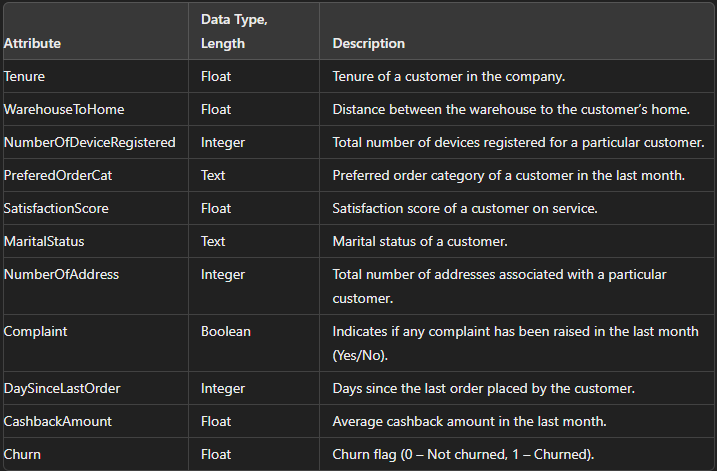

In [259]:
listItem = []
for col in data.columns :
    listItem.append([col, data[col].dtype, data[col].isna().sum(), round((data[col].isna().sum()/len(data[col])) * 100,2),
                    data[col].nunique(), list(data[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['Features', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,Features,dataType,null,nullPct,unique,uniqueSample
0,Tenure,float64,194,4.92,36,"[29.0, 19.0]"
1,WarehouseToHome,float64,169,4.29,33,"[14.0, 27.0]"
2,NumberOfDeviceRegistered,int64,0,0.00,6,"[1, 4]"
3,PreferedOrderCat,object,0,0.00,6,"[Fashion, Laptop & Accessory]"
4,SatisfactionScore,int64,0,0.00,5,"[5, 1]"
5,MaritalStatus,object,0,0.00,3,"[Divorced, Married]"
6,NumberOfAddress,int64,0,0.00,14,"[10, 7]"
7,Complain,int64,0,0.00,2,"[0, 1]"
8,DaySinceLastOrder,float64,213,5.40,22,"[14.0, 11.0]"
9,CashbackAmount,float64,0,0.00,2335,"[147.31, 114.16]"


## Interpretasi Data

1. Data tersebut memiliki 3941 baris dan 11 kolom (10 feature dan 1 target)
2. Terdapat 3 feature yang memiliki missing value, yaitu `Tenure`, `WarehouseToHome`, `DaySinceLastOrder`
3. Missing value `Tenure` sejumlah **194 data (4.92%)**
4. Missing value `WarehouseToHome` sejumlah **169 data (4.29%)**
5. Missing value `DaySinceLastOrder` sejumlah **213 data (5.40%)**

Karena nilai missingvalue cukup kecil (dibawah 6%), maka akan kita drop setiap baris yang mengandung missing value.

## Data Cleaning

In [260]:
data.dropna(inplace=True)
listItem = []
for col in data.columns :
    listItem.append([col, data[col].dtype, data[col].isna().sum(), round((data[col].isna().sum()/len(data[col])) * 100,2),
                    data[col].nunique(), list(data[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['Features', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,Features,dataType,null,nullPct,unique,uniqueSample
0,Tenure,float64,0,0.0,36,"[17.0, 23.0]"
1,WarehouseToHome,float64,0,0.0,33,"[25.0, 35.0]"
2,NumberOfDeviceRegistered,int64,0,0.0,6,"[3, 1]"
3,PreferedOrderCat,object,0,0.0,6,"[Fashion, Mobile Phone]"
4,SatisfactionScore,int64,0,0.0,5,"[4, 5]"
5,MaritalStatus,object,0,0.0,3,"[Single, Divorced]"
6,NumberOfAddress,int64,0,0.0,13,"[11, 4]"
7,Complain,int64,0,0.0,2,"[1, 0]"
8,DaySinceLastOrder,float64,0,0.0,22,"[15.0, 46.0]"
9,CashbackAmount,float64,0,0.0,2002,"[206.09, 130.57]"


Setelah itu, kita akan menghilangkan data yang memiliki outliers. Kita akan menghilangkan data outliers dengan melakukan plotting menggunakan boxplot. Dari hasil plotting tersebut, akan terlihat outliers dari masing-masing kolom/feature.

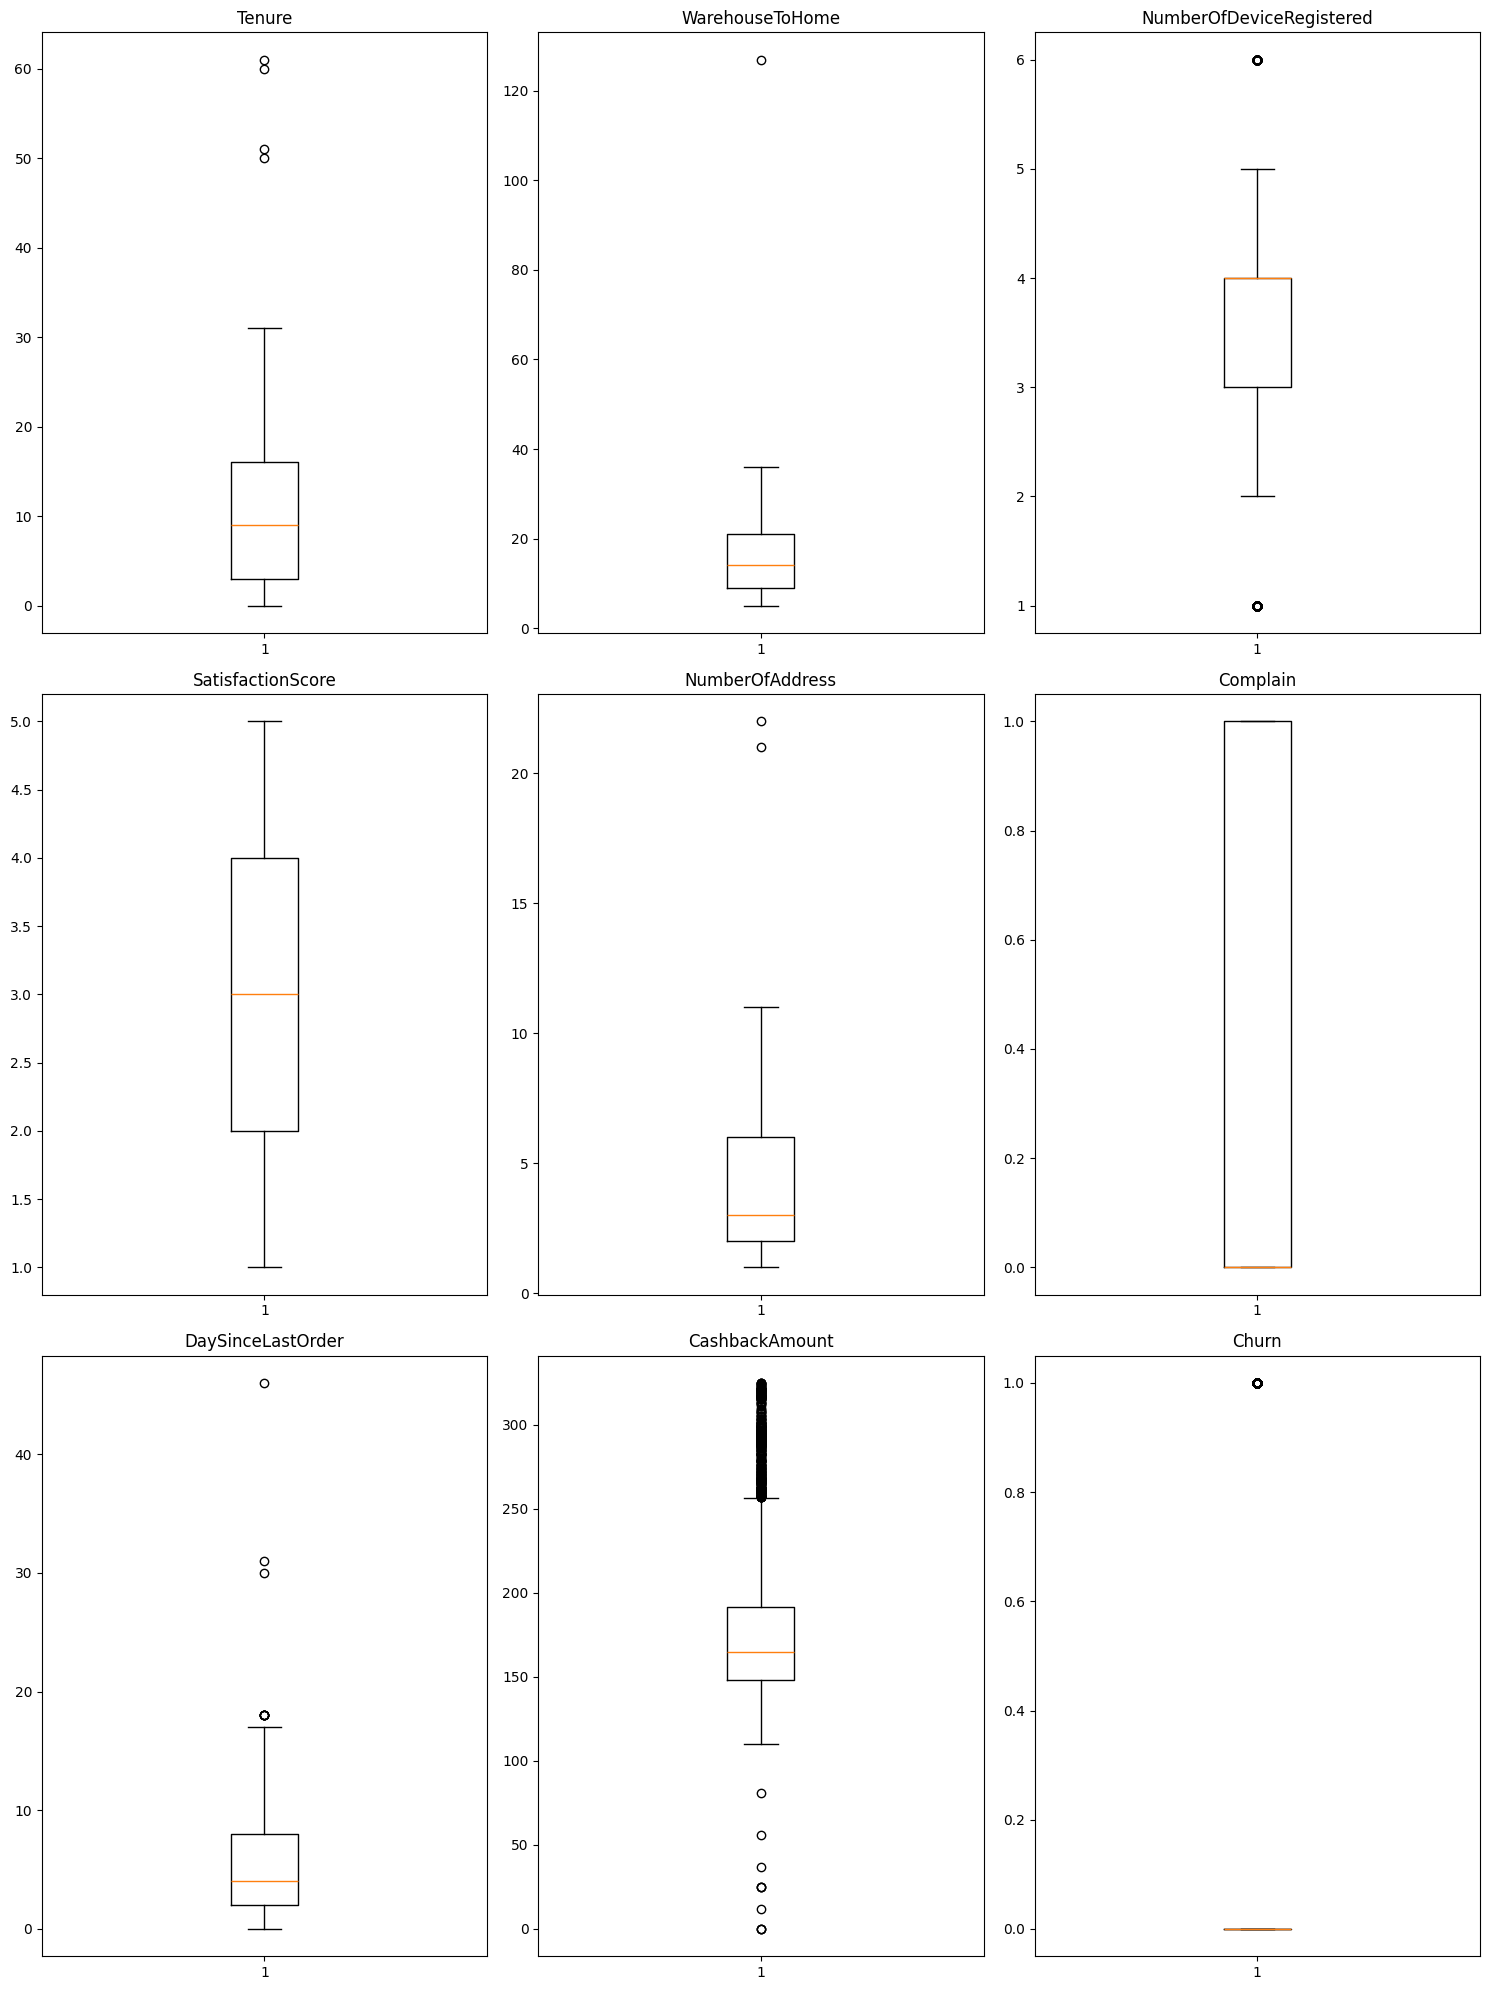

In [261]:
# Outliers - Boxplot

number_col = data.select_dtypes(include=['float64', 'int64']).columns
num_col = len(number_col)
num_row = (num_col // 3) + (num_col % 3 > 0)

plt.figure(figsize=(15,20))

for i, column in enumerate(number_col,1) :
    plt.subplot(num_row,3,i)
    plt.boxplot(data[column].dropna())
    plt.title(column)

plt.tight_layout()
plt.show()

In [262]:
# Handling extreme outliers

data = data[~((data['Tenure'] > 50) | (data['WarehouseToHome'] > 100) | (data['NumberOfAddress'] > 15) | (data['DaySinceLastOrder'] > 30))]
data

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
5,7.0,16.0,4,Mobile Phone,2,Divorced,2,0,11.0,152.81,0
...,...,...,...,...,...,...,...,...,...,...,...
3935,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0


## Cek balance data target (Churn)

In [263]:
# Check balance target 

pct = data['Churn'].value_counts(normalize=True)*100
pct

Churn
0    84.837653
1    15.162347
Name: proportion, dtype: float64

Dari data diatas, dapat dilihat bahwa dataset yang kita memiliki **IMBALANCE**, sehingga diperlukan Balancing Data pada saat pembuatan model

## Feature Importance

Pada bagian ini, kita akan memilih kolom/feature mana saja yang akan kita gunakan untuk model yang akan dibuat. Kita akan menggunakan metode **Uji Korelasi** dari setiap feature terhadap Target.

Dari hasil Uji korelasi, kita akan melihat feature mana saja yang termasuk **not important** sehingga bisa kita take out untuk tidak dimasukan ke model.

In [264]:
data['PreferedOrderCat'].unique()

array(['Laptop & Accessory', 'Mobile', 'Others', 'Mobile Phone',
       'Fashion', 'Grocery'], dtype=object)

In [265]:
data['MaritalStatus'].unique()

array(['Single', 'Married', 'Divorced'], dtype=object)

In [266]:
# Label Encoding pada data kategorikal

preferedordercat_mapping = {'Laptop & Accessory': 0, 'Mobile': 1, 'Mobile Phone': 2, 'Fashion': 3, 'Grocery':4, 'Others':5}
data['PreferedOrderCat'] = data['PreferedOrderCat'].map(preferedordercat_mapping)

maritalstat_mapping = {'Single': 0, 'Married': 1, 'Divorced': 2}
data['MaritalStatus'] = data['MaritalStatus'].map(maritalstat_mapping)

data

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,0,3,0,2,0,7.0,143.32,0
1,7.0,25.0,4,1,1,1,2,0,7.0,129.29,0
2,27.0,13.0,3,0,1,1,5,0,7.0,168.54,0
4,30.0,15.0,4,5,4,0,8,0,8.0,322.17,0
5,7.0,16.0,4,2,2,2,2,0,11.0,152.81,0
...,...,...,...,...,...,...,...,...,...,...,...
3935,26.0,7.0,4,4,1,1,4,0,9.0,295.99,0
3936,28.0,9.0,5,3,3,1,8,0,1.0,231.86,0
3937,8.0,7.0,2,2,2,0,4,0,4.0,157.80,0
3938,30.0,6.0,5,0,3,1,3,1,2.0,156.60,0


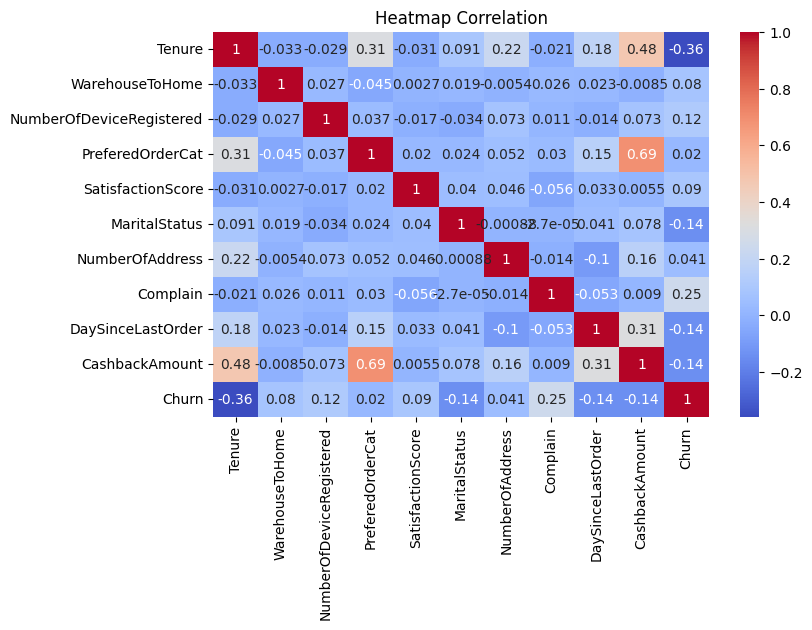

In [267]:
data.head()
plt.figure(figsize=(8,5))
sns.heatmap(data.corr('pearson'),annot=True,cmap='coolwarm')
plt.title('Heatmap Correlation')
plt.show()

Dari uji korelasi diatas, maka dapat kita simpulkan bahwa terdapat beberapa feature yang korelasinya kurang dari **absolute 0.1**. Maka dapat disimpulkan bahwa feature tersebut korelasinya sangat kecil terhadap target sehingga dapat di take out. Feature yang akan di takeout diantaranya adalah :

1. `WarehouseToHome`
2. `PreferedOrderCat`
3. `SatisfactionScore`
4. `NumberOfAddress`


In [268]:
# Menentukan Feature dan Target

X = data.drop(['WarehouseToHome','PreferedOrderCat','SatisfactionScore','NumberOfAddress','Churn'],axis=1)          #Feature
y = data['Churn']                                                                                           #Target

## Membuat Model Machine Learning

1. Mencari basemodel terbaik
2. Membuat model dengan balancing data
3. Hyperparameter tunning

### Mencari basemodel terbaik

In [269]:
# Split data

xtrain, xtest, ytrain, ytest = train_test_split(
        X, y,
        test_size=0.2,
        random_state=17,
        stratify=y)

In [270]:
# Membuat pipeline preprocessing untuk scaling data numerikal
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),  # Gunakan KNN Imputer atau bisa diubah ke Iterative Imputer
    ('scaler', RobustScaler())
])
# Gabungkan semua preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features)
    ], remainder='passthrough'
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['Tenure', 'NumberOfDeviceRegistered', 'MaritalStatus', 'Complain',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object'))])

In [312]:
knn = KNeighborsClassifier()
logreg = LogisticRegression()
svc = SVC()
dtc = DecisionTreeClassifier()

soft = VotingClassifier([
    ('knn',knn),
    ('logreg',logreg),
    ('svc',svc),
    ('dtc',dtc)
],voting='soft')

hard = VotingClassifier([
    ('knn',knn),
    ('logreg',logreg),
    ('svc',svc),
    ('dtc',dtc)
],voting='hard')

stack_knn = StackingClassifier([
    ('knn',knn),
    ('logreg',logreg),
    ('svc',svc),
    ('dtc',dtc)
],final_estimator=KNeighborsClassifier())

stack_logreg =  StackingClassifier([
    ('knn',knn),
    ('logreg',logreg),
    ('svc',svc),
    ('dtc',dtc)
],final_estimator=LogisticRegression())

stack_svc =  StackingClassifier([
    ('knn',knn),
    ('logreg',logreg),
    ('svc',svc)
],final_estimator=SVC())

stack_dtc =  StackingClassifier([
    ('knn',knn),
    ('logreg',logreg),
    ('svc',svc)
],final_estimator=DecisionTreeClassifier())

listmodel = [knn,logreg,svc,dtc,soft,hard,stack_knn,stack_logreg,stack_svc,stack_dtc]
model_name = ['KNN','Logistic Regression','SVC','DecisionTreeClassifier','Soft Voting','Hard Voting','Stacking-KNN','Stacking-LogReg','Stacking-SVC','Stacking-DTC']

hasil1 = []
for i,j in zip(listmodel,model_name) :
    pipe = Pipeline([
        ('Prepros',preprocessor),
        ('Model',i)
    ])
    accuracy = cross_val_score(pipe, xtrain, ytrain, cv=5, scoring='accuracy')
    recall = cross_val_score(pipe,xtrain,ytrain,cv=5,scoring ='recall')
    precision = cross_val_score(pipe,xtrain,ytrain,cv=5,scoring = 'precision')
    f1 = cross_val_score(pipe, xtrain, ytrain, cv=5, scoring='f1')
    hasil1.append({
        'Model' : j,
        'Avg_Accuracy': round(accuracy.mean()*100,2),
        'Avg_Recall' : round(recall.mean()*100,2),
        'Avg_Precision' : round(precision.mean()*100,2),
        'Avg_F1Score': round(f1.mean()*100,2)
    })

hasil_basemodel = pd.DataFrame(hasil1).sort_values('Avg_Recall',ascending=False).reset_index()
hasil_basemodel


,index,Model,Avg_Accuracy,Avg_Recall,Avg_Precision,Avg_F1Score
0,3,DecisionTreeClassifier,91.28,73.44,71.05,71.68
1,7,Stacking-LogReg,91.25,59.45,78.75,67.22
2,6,Stacking-KNN,90.02,58.22,70.96,64.02
3,9,Stacking-DTC,83.72,46.43,46.74,45.91
4,8,Stacking-SVC,88.19,39.55,69.28,50.27
5,0,KNN,86.67,38.80,59.49,46.57
6,1,Logistic Regression,87.97,36.85,69.65,48.11
7,5,Hard Voting,88.45,32.41,79.78,45.80
8,2,SVC,88.08,31.43,75.71,44.27
9,4,Soft Voting,NaN,NaN,NaN,NaN


Dari uji 10 basemodel diatas, model yang memiliki nilai terbaik adalah `DecisionTreeClassifier` dengan nilai **Accuracy 91.28%, Recall 73.44%, Precision 71.05%, dan F1-Score 71.68%**. Maka kita akan gunakan basemodel ini untuk ditingkatkan lagi hasilnya.

### Membuat model dengan balancing data (Model Panalized : Parameter class weight)

In [272]:
model = DecisionTreeClassifier(random_state=17,class_weight='balanced')
pipe_tree = Pipeline([
    ('PrePros',preprocessor),
    ('Model',model)
])

pipe_tree.fit(xtrain,ytrain)
yPred = pipe_tree.predict(xtest)

In [317]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

cv_results = cross_validate(pipe_tree, xtrain, ytrain, cv=5, scoring=scoring, return_train_score=False)

hasil_data = pd.DataFrame({
    'Accuracy': [round(score * 100, 2) for score in cv_results['test_accuracy']],
    'Recall': [round(score * 100, 2) for score in cv_results['test_recall']],
    'Precision': [round(score * 100, 2) for score in cv_results['test_precision']],
    'F1Score': [round(score * 100, 2) for score in cv_results['test_f1']]
})

hasil_panalized = hasil_data.sort_values('Recall',ascending=False)
hasil_panalized


,Accuracy,Recall,Precision,F1Score
4,90.69,84.51,81.45,82.85
1,89.76,81.79,79.71,80.69
0,89.20,80.95,78.67,79.73
3,86.96,79.81,75.07,77.05
2,86.96,75.57,74.58,75.06


Dari uji penerapan model panalized untuk mengatasi imbalance dataset, hasil yang dihasilkan membaik dibandingkan dengan sebelumnya. Sekarang hasil model menjadi: 
1. Accuracy : 90.69% (Turun 0.59%)
2. Recall : 84.51% (Naik 11.07%)
3. Precision : 81.45% (Naik 10.4%)
4. F1-Score : 82.85% (Naik 11.17%)

Meskipun nilai accuracy turun 0.59%, parameter lain naik diangka sekitar 10-11%. Hal ini menunjukan bahwa model lebih baik dalam meprediksi customer churn.

### Membuat model dengan balancing data (Over Sampling)

In [274]:
ros = RandomOverSampler(random_state=17)
adasyn = ADASYN(random_state=17)
smote = SMOTE(random_state=17)
bsmote = BorderlineSMOTE(random_state=17)
KMeansSMOTE = KMeansSMOTE(random_state=17)
svm = SVMSMOTE(random_state=17)

oversm = [ros,adasyn,smote,bsmote,KMeansSMOTE,svm]
oversm_names = ['Random Over Sampler', 'ADASYN', 'SMOTE', 'BorderlineSMOTE', 'KMeansSMOTE', 'SVMSMOTE']


In [296]:
# Komparisasi hasil oversampling

accuracy = []
recall = []
prec = []
f1scores = []

for i, name in zip(oversm, oversm_names):
    model = DecisionTreeClassifier(random_state=17)
    pipe_tree_os = Pipeline([
        ('PrePros', preprocessor),
        ('resamp', i), 
        ('Model', model)
    ])

    try:
        pipe_tree_os.fit(xtrain, ytrain)
        yPred = pipe_tree_os.predict(xtest)
        
        accuracy.append(round(accuracy_score(ytest, yPred) * 100, 2))
        recall.append(round(recall_score(ytest, yPred) * 100, 2))
        prec.append(round(precision_score(ytest, yPred) * 100, 2))
        f1scores.append(round(f1_score(ytest, yPred, average='macro') * 100, 2))
    except RuntimeError as e:
        print(f"Error with {name}: {e}")
        accuracy.append(None)
        recall.append(None)
        prec.append(None)
        f1scores.append(None)

# Create DataFrame to display results
hasil_os = pd.DataFrame({
    'Metode Oversampling': oversm_names,
    'Accuracy': accuracy,
    'Recall': recall,
    'Precision': prec,
    'F1Score': f1scores
}).sort_values('Recall', ascending=False)

hasil_os

Error with KMeansSMOTE: No clusters found with sufficient samples of class 1. Try lowering the cluster_balance_threshold or increasing the number of clusters.


,Metode Oversampling,Accuracy,Recall,Precision,F1Score
1,ADASYN,89.29,80.39,61.19,81.50
3,BorderlineSMOTE,90.62,80.39,65.60,83.30
5,SVMSMOTE,90.48,79.41,65.32,82.98
2,SMOTE,89.88,76.47,63.93,81.79
0,Random Over Sampler,92.86,75.49,77.00,86.02
4,KMeansSMOTE,NaN,NaN,NaN,NaN


## Hasil dari Basemodel, Model Panalized, dan Model Over Sampling

In [318]:
print('Hasil Basemodel:')
hasil_basemodel

Hasil Basemodel:


,index,Model,Avg_Accuracy,Avg_Recall,Avg_Precision,Avg_F1Score
0,3,DecisionTreeClassifier,91.28,73.44,71.05,71.68
1,7,Stacking-LogReg,91.25,59.45,78.75,67.22
2,6,Stacking-KNN,90.02,58.22,70.96,64.02
3,9,Stacking-DTC,83.72,46.43,46.74,45.91
4,8,Stacking-SVC,88.19,39.55,69.28,50.27
5,0,KNN,86.67,38.80,59.49,46.57
6,1,Logistic Regression,87.97,36.85,69.65,48.11
7,5,Hard Voting,88.45,32.41,79.78,45.80
8,2,SVC,88.08,31.43,75.71,44.27
9,4,Soft Voting,NaN,NaN,NaN,NaN


In [319]:
print('Hasil Model Panalized Decission Tree Classifier:')
hasil_panalized

Hasil Model Panalized Decission Tree Classifier:


,Accuracy,Recall,Precision,F1Score
4,90.69,84.51,81.45,82.85
1,89.76,81.79,79.71,80.69
0,89.20,80.95,78.67,79.73
3,86.96,79.81,75.07,77.05
2,86.96,75.57,74.58,75.06


In [320]:
print('Hasil Model Oversampling Decission Tree Classifier:')
hasil_os

Hasil Model Oversampling Decission Tree Classifier:


,Metode Oversampling,Accuracy,Recall,Precision,F1Score
1,ADASYN,89.29,80.39,61.19,81.50
3,BorderlineSMOTE,90.62,80.39,65.60,83.30
5,SVMSMOTE,90.48,79.41,65.32,82.98
2,SMOTE,89.88,76.47,63.93,81.79
0,Random Over Sampler,92.86,75.49,77.00,86.02
4,KMeansSMOTE,NaN,NaN,NaN,NaN


**KESIMPULAN**

Dari hasil pencarian basemodel lalu dilakukan panalized model dan oversampling, didapatkan bahwa model terbaik adalah basemodel **Decision Tree Classifier dengan panalized model (parameter class weight = balance)**. Nilai metriks dari model ini adalah :

1. Accuracy : 90.69%
2. Recall : 84.51%
3. Precision : 81.45%
4. F1-Score : 82.85%

Dari hasil panalized model, kita akan lanjutkan lagi untuk melakukan hyperparameter tunning untuk mencari paramater yang paling tepat sehingga didapatkan metriks yang lebih baik lagi

## Hyperparameter Tunning

In [306]:
# Parameter DTC
dtc_param = {
    'clf__criterion': ['gini', 'entropy', 'log_loss'],
    'clf__max_depth': np.arange(1,51,1),
    'clf__min_samples_split': np.arange(1,51,1),
    'clf__class_weight': ['balanced']
}

# Pipeline Gridsearch
dtc_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', DecisionTreeClassifier())
])

# GridSearchCV
dtc_Grid = GridSearchCV(estimator=dtc_pipe, param_grid=dtc_param, cv=5, scoring='recall', n_jobs=-1)

# Fitting Model
dtc_Grid.fit(xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['Tenure', 'NumberOfDeviceRegistered', 'MaritalStatus', 'Complain',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object'))])),
                                       ('clf', DecisionTreeClassifier())...
                         'clf__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'clf__min_samples_split': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='recall')

In [307]:
best_dtc_model = dtc_Grid.best_estimator_

In [308]:
dtc_Grid.best_params_

{'clf__class_weight': 'balanced',
 'clf__criterion': 'entropy',
 'clf__max_depth': 16,
 'clf__min_samples_split': 50}

In [309]:
best_model = Pipeline([
    ('prepros', preprocessor),
    ('model', DecisionTreeClassifier(criterion='entropy',max_depth=16,min_samples_split=50,class_weight='balanced'))
])

best_model.fit(xtrain, ytrain)

Pipeline(steps=[('prepros',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['Tenure', 'NumberOfDeviceRegistered', 'MaritalStatus', 'Complain',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=16,
                                        min_samples_split=50))])

In [321]:
yPred_best = best_model.predict(xtest)

scoring_best = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='macro'),
    'precision': make_scorer(precision_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

cv_results_best = cross_validate(best_model, xtrain, ytrain, cv=5, scoring=scoring_best, return_train_score=False)

hasil_data_best= pd.DataFrame({
    'Accuracy': [round(score * 100, 2) for score in cv_results_best['test_accuracy']],
    'Recall': [round(score * 100, 2) for score in cv_results_best['test_recall']],
    'Precision': [round(score * 100, 2) for score in cv_results_best['test_precision']],
    'F1Score': [round(score * 100, 2) for score in cv_results_best['test_f1']]
})

hasil_best = hasil_data_best.sort_values('Recall',ascending=False)
hasil_best

,Accuracy,Recall,Precision,F1Score
4,85.10,86.21,74.09,77.44
1,82.68,85.23,71.90,74.82
0,83.24,83.53,71.79,74.78
2,83.80,81.83,71.77,74.70
3,78.03,81.53,68.41,70.06


Ketika dilakukan hyperpameter tunning, hasil yang dihasilkan malah turun dari sebelumnya. Hal ini menunjukan bahwa parameter terbaik dalam membuat model ini adalah **Model Decission Tree Classifier dengan parameter class_weight='Balanced' dan parameter lainnya DEFAULT**

# Conlusion & Recommendation

## Conclusion

Hasil akhir dari percobaan pembuatan model untuk case memprediksi customer churn adalah **MODEL DECISSION TREE CLASSIFIER, PARAMETER CLASS_WEIGHT='BALANCED'**

Berikut hasil metriks pengujian dari model tersebut :

In [322]:
hasil_panalized

,Accuracy,Recall,Precision,F1Score
4,90.69,84.51,81.45,82.85
1,89.76,81.79,79.71,80.69
0,89.20,80.95,78.67,79.73
3,86.96,79.81,75.07,77.05
2,86.96,75.57,74.58,75.06


Dari tabel hasil model diatas, dapat disimpulkan bahwa :

* Model dapat memprediksi 90.69% customer churn dari total semua kasus churn atau tidak yang dilakukan oleh model yang kita buat (Accuracy).
* Model dapat melakukan  81.45%% prediksi customer churn dibandingkan dengan semua customer yang melakukan churn. Dengan kata lain, jika terdapat 100 customer churn, model dapat memprediksi sebanyak 81 orang. Hal ini dapat menjadi landasan perusahaan agar tepat mengeluarkan budget ke customer yang tepat (Recall)
* Model dapat melakukan 84.51% prediksi secara benar baik customer tersebut melakukan churn atau tidak churn. Dengan kata lain, jika terdapat 100 customer (baik churn atau tidak), model dapat memprediksi 84 orang secara benar (baik churn atau tidak)
* Model menunjukan keseimbangan sebesar 82.84% antara recall maupun precision (f1-score). Model memiliki keseimbangan yang baik antara kemampuan untuk mendeteksi churn dan menghindari prediksi palsu/salah.


Jika kita berfokus dalam penghematan budget agar semua budget dikeluarkan ke customer yang tepat (yang benar melakukan Churn), maka kita harus fokus pada 2 parameter yaitu Recall & Precision. Berikut penjelasannya :

1. Recall = Berarti kita fokus terhadap model agar dapat memprediksi sebanyak-banyaknya customer yang melakukan churn
2. Precision = Berarti kita fokus agar menghindari prediksi terhadap pelanggan yang tidak melakukan churn. Hal ini bertujuan agar budget yang kita keluarkan tepat sasaran.

Bila seandainya budget yang dimiliki perusahaan untuk alokasi khusus Customer Churn agar tidak melakukan churn adalah 250.000/Customer. Dan total customer yang berpotensi melakukan churn adalah 2.000 customer. Maka perhitungan penghematan budgetnya akan seperti ini :

* Total Budget yang dibutuhkan jika **tanpa model** = 250.000 x 2.000 = 500.000.000

Dari total 2.000 customer, maka :

* Jumlah pelanggan yang diprediksi churn (dengan presisi 81.45%) = 2.000 × 81.45% = 1.628 pelanggan.
* Dari 1.628 pelanggan yang diprediksi churn, 84.51% benar-benar churn, yaitu: 1.628 × 84.51% ≈ 1.375 pelanggan churn sebenarnya.
* Jadi, 1.628 - 1.375 = 253 pelanggan adalah false positives.

Jadi, penghematan yang dapat dilakukan dengan model ini adalah :

* Penghematan = False Positives × Biaya per Pelanggan
  Pengehematan = 253 x 250.000 = **63.250.000**

* Total Budget yang dibutuhkan **dengan model** = 500.000.000 - 63.250.000 = **456.750.000**
* Presentase penghematan budget **dengan model** = (63.250.000/500.000.000)x100 = **12.65%**

Berdasarkan perhitungan diatas, dapat dilihat bahwa model kita dapat menghemat budget sekitar 12.65%. Hal ini menunjukan bahwa ketika kita menggunakan model, perusahaan dapat mengurangi False Positive yang akan menghemat 12.65% budget yang mereka miliki

## Recommendation

Rekomendasi kami terhadap perusahaan diantaranya adalah :

1. Membuat kebijakan kepada perusahaan untuk mengisi data-data yang memiliki korelasi terhadap customer churn sebagai *kewajiban*. Hal ini agar mengurangi missing values pada feature yang penting
2. Jika memungkinkan, perusahaan menambahkan feature atau data terbaru yang mungkin bisa memiliki hubungan terhadap customer churn. Seperti umur customer, amount of spent customer, dan hal lainnya.
3. Mencoba algorithm lain ada Machine Learning yang memungkinkan kenaikan nilai metriks pada model. Atau melakukan tunning parameter dengan skala yang lebih panjang lagi yang memungkinkan nilai metriks membaik
4. Melakukan analisa pada data yang salah kita prediksi agar dapat meningkatkan kemampuan model dalam memprediksi

# THANK YOU!